# <p style="text-align: center;"> <b> Data Modeling </b> </p>


---

# Table of Contents

---

# 1. Problem Statement <a class="anchor" id="1"></a>

- Bài toán: Dự đoán số điểm của một bộ manga dựa trên các thông tin về bộ manga đó.

- Mô tả: 

- What are the purposes/benefits of solving this problem?

# 2. Data Preparation <a class="anchor" id="2"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast # for literal_eval

In [2]:
manga_df = pd.read_csv('../data/processed_comic.csv')
manga_df.head(3)

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Volumes,Chapters,Status,Genres,Author,Recommended,Mixed Feelings,Not Recommended,Release date,Completed date
0,Berserk,9.47,331288,1,1,665300,122841,4,28,Publishing,"['Action', 'Adventure', 'Award Winning', 'Dram...","['Miura Kentarou', 'Studio Gaga']",233,15,10,1989-08-25,2023-12-10
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,9.30,156368,2,26,256146,42864,24,96,Finished,"['Action', 'Adventure', 'Mystery', 'Supernatur...",['Araki Hirohiko'],120,7,1,2004-01-19,2011-04-19
2,Vagabond,9.24,136403,3,15,364891,40158,37,327,On Hiatus,"['Action', 'Adventure', 'Award Winning']","['Inoue Takehiko', 'Yoshikawa Eiji']",88,8,1,1998-09-03,2015-05-21


## 2.1 Feature Engineering & Preprocessing <a class="anchor" id="2.1"></a>

Observations and feature selection:

- Two features, `Title` and `Author`, have a large number of unique values and do not provide meaningful insights for analyzing or predicting the score of a manga series. Therefore, we will drop these two features.
- The `Genres` feature represents a multi-label category, so we need to convert it to a list type first.
- The `Status` feature will be converted to numerical values using ordinal encoding.
- Two features, `Released date` and `Completed date`, will be converted to datetime type.

Subsequently, we will use a correlation matrix to examine the correlations between features. This will help us identify features with high correlation with Score and discard features with low correlation.

In [3]:
from sklearn.preprocessing import LabelEncoder


new_df = manga_df.drop(columns=['Title', 'Author'])

new_df[['Release date', 'Completed date']] = new_df[['Release date', 'Completed date']].apply(pd.to_datetime)
# Convert 'Genres' into list of strings
new_df['Genres'] = new_df['Genres'].apply(ast.literal_eval)

label_encoder = LabelEncoder()
new_df['Status'] = label_encoder.fit_transform(new_df['Status'])

Now we calculate and visualize the correlation matrix to see the correlation between features and the target variable.

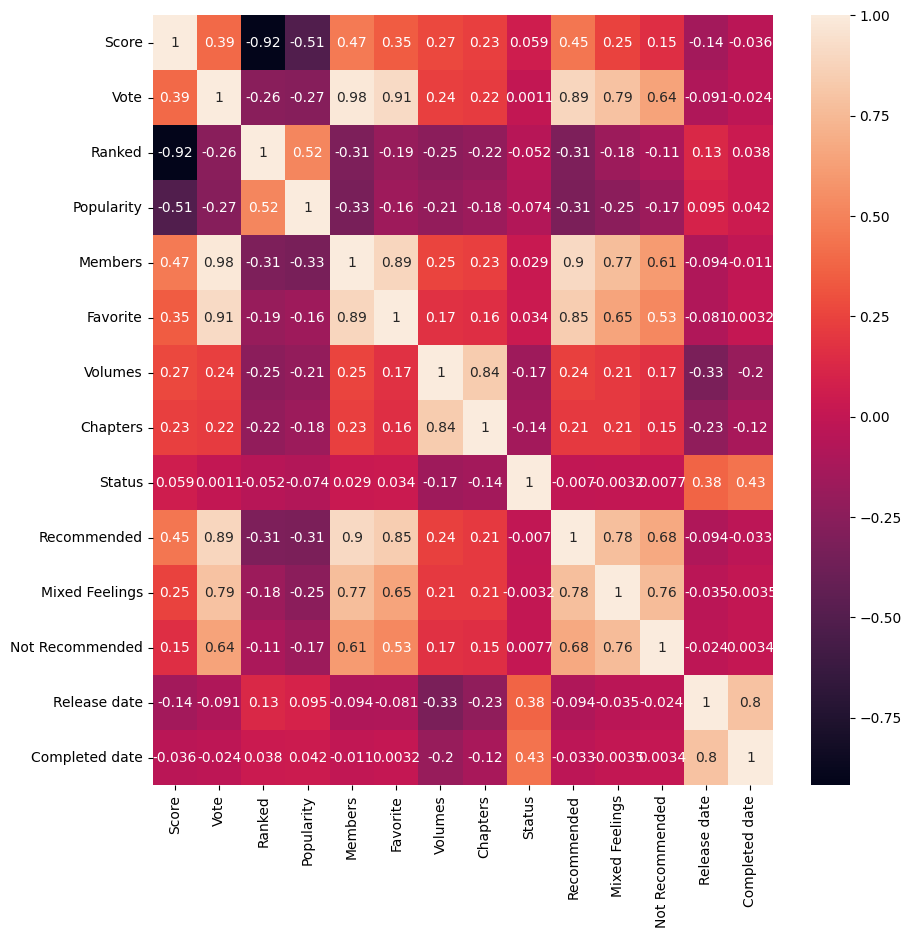

In [4]:
corr = new_df[['Score', 'Vote', 'Ranked' ,'Popularity', 'Members', 'Favorite','Volumes','Chapters','Status','Recommended','Mixed Feelings','Not Recommended','Release date','Completed date']].corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, ax=ax)
plt.show()

`Status`, `Not Recommended`, `Released date` and `Completed date` have low correlation with `Score` and will be dropped.

In [5]:
new_df = new_df.drop(columns=['Status', 'Release date', 'Completed date','Not Recommended'])
new_df.head(3)

,Score,Vote,Ranked,Popularity,Members,Favorite,Volumes,Chapters,Genres,Recommended,Mixed Feelings
0,9.47,331288,1,1,665300,122841,4,28,"[Action, Adventure, Award Winning, Drama, Fant...",233,15
1,9.30,156368,2,26,256146,42864,24,96,"[Action, Adventure, Mystery, Supernatural]",120,7
2,9.24,136403,3,15,364891,40158,37,327,"[Action, Adventure, Award Winning]",88,8


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from sklearn.preprocessing import MultiLabelBinarizer

# Convert 'Genres' into binary columns
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(new_df['Genres']), columns=mlb.classes_, index=new_df.index)
df = pd.concat([new_df, genres_encoded], axis=1)

features = ['Vote', 'Ranked', 'Popularity', 'Members', 'Favorite', 'Volumes', 'Chapters',
            'Recommended', 'Mixed Feelings'] + list(mlb.classes_)
target = 'Score'

# Tạo DataFrame mới với các features được chọn
new_df = df[features + [target]]

## 2.3 Split data <a class="anchor" id="2.3"></a>

In [7]:
# Chia dữ liệu thành tập train, validation, và test
train_data, test_data = train_test_split(new_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Chia features và target
X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

In [8]:

models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(),
    'Random Forest': RandomForestRegressor()
}
n_folds = 5
mse_results = np.zeros((len(models),n_folds))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
historys = []
for i, (name, model) in enumerate(models.items()):
    for j, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        history = model.fit(X_train_fold, y_train_fold)
        historys.append(history)
        
        y_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred)
        mse_results[i,j] = mse
        print(f'{name} Fold {j+1}: {mse:.5f}')
    
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} Test Score: {mse:.5f}\n')
    


Linear Regression Fold 1: 0.01298
Linear Regression Fold 2: 0.01638
Linear Regression Fold 3: 0.01321
Linear Regression Fold 4: 0.01757
Linear Regression Fold 5: 0.01573
Linear Regression Test Score: 0.01860

XGBoost Fold 1: 0.00005
XGBoost Fold 2: 0.00007
XGBoost Fold 3: 0.00006
XGBoost Fold 4: 0.00030
XGBoost Fold 5: 0.00016
XGBoost Test Score: 0.00012

Random Forest Fold 1: 0.00001
Random Forest Fold 2: 0.00001
Random Forest Fold 3: 0.00001
Random Forest Fold 4: 0.00011
Random Forest Fold 5: 0.00002
Random Forest Test Score: 0.00002



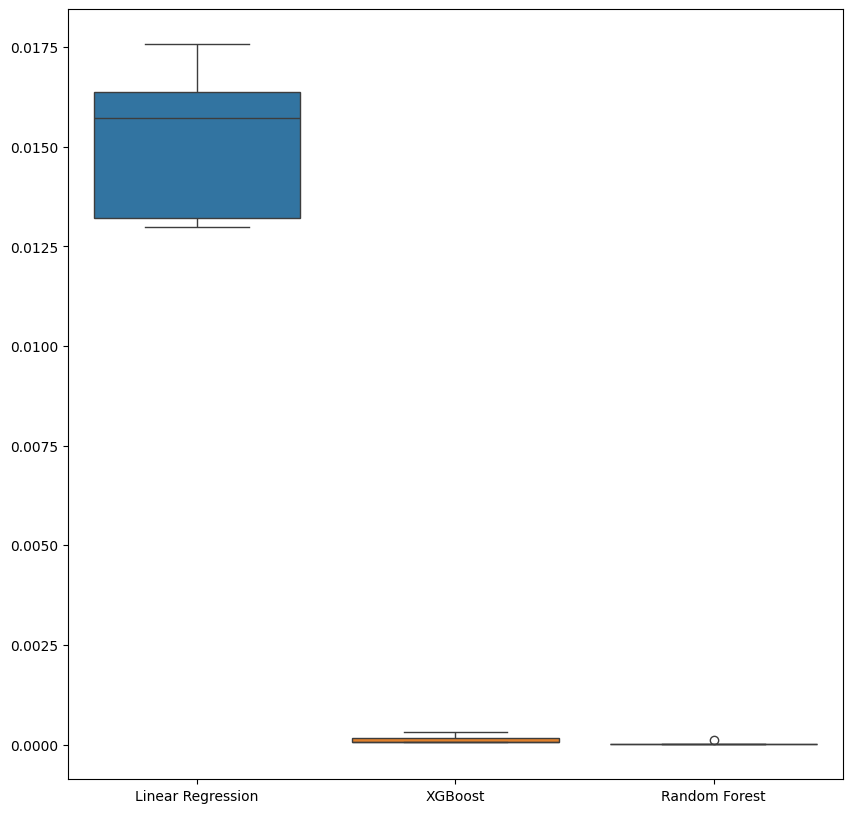

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=pd.DataFrame(mse_results.T, columns=models.keys()), ax=ax)
plt.show()

In [13]:
params_rf = {
    'n_estimators': (10, 100),
    'max_depth': (1, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

params_xgb = {
    'n_estimators': (10, 100),
    'max_depth': (1, 10),
    'learning_rate': (1e-3, 1e-1, 'log-uniform'),
    'gamma': (1e-3, 1e-1, 'log-uniform'),
    'min_child_weight': (1, 10),
    'subsample': (0.1, 1.0, 'uniform'),
    'colsample_bytree': (0.1, 1.0, 'uniform')
}


opt = BayesSearchCV(
    RandomForestRegressor(),
    params_rf,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42
)
np.int = int
opt.fit(X_train, y_train)
print(opt.best_params_)
print(opt.best_score_)
print(opt.score(X_test, y_test))

opt = BayesSearchCV(
    XGBRegressor(),
    params_xgb,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42
)

opt.fit(X_train, y_train)
print(opt.best_params_)
print(opt.best_score_)
print(opt.score(X_test, y_test))

model = RandomForestRegressor(**opt.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Random Forest Test Score: {mse:.5f}')

model = XGBRegressor(**opt.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'XGBoost Test Score: {mse:.5f}')

OrderedDict([('max_depth', 7), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 10)])
0.9998370075745256
0.9999421279633917
OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.1), ('learning_rate', 0.1), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 100), ('subsample', 1.0)])
0.9985236185522786
0.9993664284254326


TypeError: __init__() got an unexpected keyword argument 'colsample_bytree'

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np

# Chia dữ liệu thành features và target
X = data.drop(target_column, axis=1).values
y = data[target_column].values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Chia thành tập train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Chuyển dữ liệu thành Tensor
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Xây dựng mô hình
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hàm huấn luyện mô hình
def train_model(model, train_loader, val_loader, num_epochs=200, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels)

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss.item():.3f}')

# Hàm tính score
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            true_labels.extend(labels.numpy())

    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    return mse, r2


# Tạo và huấn luyện mô hình
input_size = X_train.shape[1]
model = RegressionModel(input_size)
train_model(model, train_loader, val_loader)

# Đánh giá trên tập train
train_mse, train_r2 = evaluate_model(model, train_loader)
print(f'Train Mean Squared Error: {train_mse:.3f}, Train R^2 Score: {train_r2:.3f}')

# Đánh giá trên tập validation
val_mse, val_r2 = evaluate_model(model, val_loader)
print(f'Validation Mean Squared Error: {val_mse:.3f}, Validation R^2 Score: {val_r2:.3f}')

# Đánh giá trên tập test
test_mse, test_r2 = evaluate_model(model, test_loader)
print(f'Test Mean Squared Error: {test_mse:.3f}, Test R^2 Score: {test_r2:.3f}')


Epoch 1/200, Validation Loss: 365.399
Epoch 2/200, Validation Loss: 153.613
Epoch 3/200, Validation Loss: 40.466
Epoch 4/200, Validation Loss: 19.731
Epoch 5/200, Validation Loss: 15.176
Epoch 6/200, Validation Loss: 12.195
Epoch 7/200, Validation Loss: 9.722
Epoch 8/200, Validation Loss: 7.900
Epoch 9/200, Validation Loss: 6.581
Epoch 10/200, Validation Loss: 5.416
Epoch 11/200, Validation Loss: 4.710
Epoch 12/200, Validation Loss: 4.073
Epoch 13/200, Validation Loss: 3.604
Epoch 14/200, Validation Loss: 3.269
Epoch 15/200, Validation Loss: 2.968
Epoch 16/200, Validation Loss: 2.660
Epoch 17/200, Validation Loss: 2.479
Epoch 18/200, Validation Loss: 2.344
Epoch 19/200, Validation Loss: 2.207
Epoch 20/200, Validation Loss: 2.085
Epoch 21/200, Validation Loss: 1.969
Epoch 22/200, Validation Loss: 1.886
Epoch 23/200, Validation Loss: 1.802
Epoch 24/200, Validation Loss: 1.721
Epoch 25/200, Validation Loss: 1.666
Epoch 26/200, Validation Loss: 1.610
Epoch 27/200, Validation Loss: 1.549
Ep

In [7]:
manga_df= pd.read_csv('../data/processed_comic.csv')
test_manga_df = manga_df.iloc[:,1:9]
test_manga_df

,Score,Vote,Ranked,Popularity,Members,Favorite,Volumes,Chapters
0,9.47,331288,1,1,665300,122841,4,28
1,9.30,156368,2,26,256146,42864,24,96
2,9.24,136403,3,15,364891,40158,37,327
3,9.22,366668,4,3,599278,114531,4,28
4,9.15,93945,5,29,236355,20501,18,162
...,...,...,...,...,...,...,...,...
6122,6.91,632,9856,9083,1878,7,4,28
6123,6.91,488,9857,12964,1159,1,1,5
6124,6.91,218,9860,11610,1354,12,6,31
6125,6.91,137,9862,14815,954,9,10,28


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

3675 1226 1226
Epoch 1/20 - Train Loss: 53.11239446442703, Validation Loss: 52.786617279052734
Epoch 2/20 - Train Loss: 52.17548403246649, Validation Loss: 51.806034088134766
Epoch 3/20 - Train Loss: 51.233217305150525, Validation Loss: 50.88002395629883
Epoch 4/20 - Train Loss: 50.30959938312399, Validation Loss: 49.990379333496094
Epoch 5/20 - Train Loss: 49.421995689129005, Validation Loss: 49.11238098144531
Epoch 6/20 - Train Loss: 48.614478078381765, Validation Loss: 48.270713806152344
Epoch 7/20 - Train Loss: 47.74652592889194, Validation Loss: 47.436004638671875
Epoch 8/20 - Train Loss: 46.93489548255657, Validation Loss: 46.63582229614258
Epoch 9/20 - Train Loss: 46.160721811754954, Validation Loss: 45.84113311767578
Epoch 10/20 - Train Loss: 45.36713271305479, Validation Loss: 45.064151763916016
Epoch 11/20 - Train Loss: 44.602665539445546, Validation Loss: 44.29806137084961
Epoch 12/20 - Train Loss: 43.836633616480334, Validation Loss: 43.5494384765625
Epoch 13/20 - Train Los

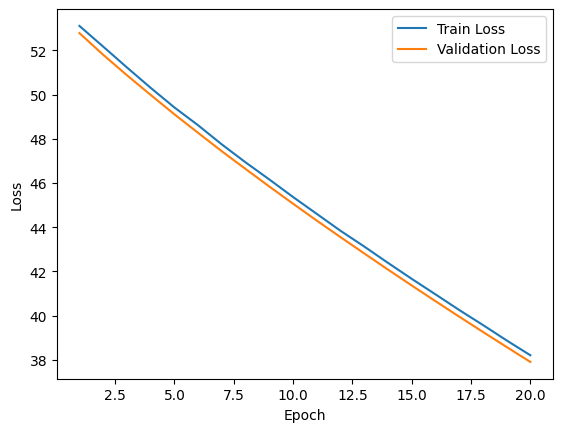

Mean Squared Error on Test Set: 37.965360371726334, -226.94425957515767


,Score
0,1.489863
1,0.803228
2,1.215603
3,1.433375
4,1.214188
...,...
1221,1.078538
1222,1.445740
1223,1.693596
1224,1.030253


In [17]:
X_train, X_test, y_train, y_test = train_test_split(test_manga_df.drop('Score', axis=1), test_manga_df['Score'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(len(X_train), len(X_test), len(X_val))
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors and create DataLoader
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define your linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize model, loss function, optimizer
model = LinearRegressionModel(input_size=X_train.shape[1])
criterion = nn.MSELoss()

# Choose your optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
train_losses = []
val_losses = []
best_model = None
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_loss}, Validation Loss: {val_loss.item()}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
# Plot the training and validation losses over epochs
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.load_state_dict(best_model)
# Test the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_mse = mean_squared_error(y_test, test_outputs.numpy())
    test_r2 = r2_score(y_test, test_outputs.numpy())
print(f'Mean Squared Error on Test Set: {test_mse}, {test_r2}')
# predict
predict = model(X_test_tensor)
predict = predict.detach().numpy()
predict = pd.DataFrame(predict)
predict.columns = ['Score']
predict